In [12]:
import os
import zipfile

def unzip_files_in_directory(directory_path):
    # Ellenőrizzük, hogy létezik-e a megadott mappa
    if not os.path.isdir(directory_path):
        print(f"Hiba: '{directory_path}' nem létező könyvtár.")
        return

    # Végigmegyünk az összes fájlon a megadott mappán belül
    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)

        # Csak .zip fájlokat csomagolunk ki
        if os.path.isfile(file_path) and file_name.endswith('.zip'):
            # Létrehozzuk a kicsomagolási célmappát a zip fájl neve alapján (kiterjesztés nélkül)
            extract_folder_name = os.path.splitext(file_name)[0]
            extract_path = os.path.join(directory_path, extract_folder_name)

            # Kicsomagoljuk a zip fájlt a megadott mappába
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            print(f"'{file_name}' sikeresen kicsomagolva '{extract_folder_name}' mappába.")

    print("Az összes zip fájl kicsomagolása befejeződött.")

# Használat
directory_path = "./train"
unzip_files_in_directory(directory_path)
directory_path = "./valid"
unzip_files_in_directory(directory_path)

'train_pics.zip' sikeresen kicsomagolva 'train_pics' mappába.
Az összes zip fájl kicsomagolása befejeződött.
'valid_data.zip' sikeresen kicsomagolva 'valid_data' mappába.
Az összes zip fájl kicsomagolása befejeződött.


In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from keras.api.applications.vgg19 import VGG19
from keras.applications import EfficientNetB1, EfficientNetB7
from keras.api.applications.vgg19 import preprocess_input, decode_predictions
from keras.api.layers import Dense, Flatten, Dropout, Activation,GlobalAveragePooling2D,Lambda, RandomRotation, RandomZoom, RandomFlip, RandomTranslation

# 1. Adatok előkészítése
# CSV betöltése
data_dir_train = "./train/train_pics"  # A képek könyvtára
labels_train_df = pd.read_csv("./train/encoded_species_train.csv", sep=',')  # Címkék CSV fájl

data_dir_valid = "./valid/valid_data"  # A képek könyvtára
labels_valid_df = pd.read_csv("./valid/encoded_species_valid.csv", sep=',')  # Címkék CSV fájl
labels_valid_df['poisonous'].value_counts()


poisonous
0    6218
1     190
Name: count, dtype: int64

In [3]:
from keras.api.models import Model, Sequential
from keras import layers
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
# Címkék és file path-ek betöltése
file_paths_train = [f"{data_dir_train}/{fname}" for fname in labels_train_df["image_path"]]
species_labels_train = labels_train_df["species_encoded"].values  # Többosztályos címkék
toxicity_labels_train = labels_train_df["poisonous"].values  # Bináris címkék

file_paths_valid = [f"{data_dir_valid}/{fname}" for fname in labels_valid_df["image_path"]]
species_labels_valid = labels_valid_df["species_encoded"].values  # Többosztályos címkék
toxicity_labels_valid = labels_valid_df["poisonous"].values  # Bináris címkék

In [5]:
# Egyéni adatbetöltő függvény
def preprocess_image(filename, species_label, toxicity_label):
    # Kép betöltése és átméretezése
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (220, 220))
    return image, {"species": species_label, "toxicity": toxicity_label}

# TensorFlow dataset létrehozása
file_paths_ds_train = tf.data.Dataset.from_tensor_slices((file_paths_train, species_labels_train, toxicity_labels_train))
dataset_train = file_paths_ds_train.map(preprocess_image)

file_paths_ds_valid = tf.data.Dataset.from_tensor_slices((file_paths_valid, species_labels_valid, toxicity_labels_valid))
dataset_valid = file_paths_ds_valid.map(preprocess_image)

# Adat split (train és validation)
train_size = int(len(file_paths_train))
train_dataset = dataset_train.take(train_size).batch(32).shuffle(1000)

valid_size = int(len(file_paths_valid))
valid_dataset = dataset_valid.take(valid_size).batch(32).shuffle(1000)
len(train_dataset)
len(valid_dataset)


201

In [7]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

#base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(130, 130, 3))
second_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(220, 220, 3))
#third_model = ResNet50(weights='imagenet', include_top=False, input_shape=(130, 130, 3))

#for layer in base_model.layers:
#     layer.trainable = False

for layer in second_model.layers:
     layer.trainable = False

#for layer in third_model.layers:
#     layer.trainable = False

In [8]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_macro(y_true, y_pred):
    # Convert predictions to class indices if needed
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.cast(y_true, tf.int64)

    # Get the number of classes dynamically
    num_classes = tf.reduce_max(y_true) + 1

    # Initialize a tensor to store F1 scores for each class
    f1_scores = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)

    # Use tf.range instead of Python's range
    for i in tf.range(num_classes):
        # Calculate precision and recall for class i
        true_positive = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_pred, i), tf.equal(y_true, i)), tf.float32))
        predicted_positive = tf.reduce_sum(tf.cast(tf.equal(y_pred, i), tf.float32))
        actual_positive = tf.reduce_sum(tf.cast(tf.equal(y_true, i), tf.float32))

        precision = true_positive / (predicted_positive + K.epsilon())
        recall = true_positive / (actual_positive + K.epsilon())

        # Calculate F1 score for the class
        f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        f1_scores = f1_scores.write(i, f1)

    # Stack F1 scores and compute their mean (macro F1)
    macro_f1 = tf.reduce_mean(f1_scores.stack())
    return macro_f1


In [9]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K

# Initialize Precision and Recall for F1 calculation
precision = Precision()
recall = Recall()

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * (p * r) / (p + r + K.epsilon())


In [10]:

c_PSC = tf.constant(100.0, dtype=tf.float32)  # Költség a mérgező tévesztésnél
c_ESC = tf.constant(1.0, dtype=tf.float32)    # Költség a nem mérgező tévesztésnél


def toxicity_confusion_loss(y_true, y_pred):
    # `y_true` és `y_pred` bináris értékek, ahol a 0 = nem mérgező, és 1 = mérgező
    confusion_cost = tf.where(
        tf.logical_and(tf.equal(y_true, 1), tf.equal(tf.round(y_pred), 0)),  # mérgezőre nem mérgezőt tippeltünk
        c_PSC,
        tf.where(
            tf.logical_and(tf.equal(y_true, 0), tf.equal(tf.round(y_pred), 1)),  # nem mérgezőre mérgezőt tippeltünk
            c_ESC,
            tf.constant(0.0, dtype=tf.float32)
        )
    )
    # végül a bináris keresztentrópia + tévesztési hibafüggvényt adjuk vissza
    base_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return base_loss + confusion_cost


In [11]:
def crop_center(image):
    cropped_image = tf.image.central_crop(image, central_fraction=0.8)  # 80%-os középső rész
    resized_image = tf.image.resize(cropped_image, (220, 220))          # Resize 130x130-ra
    return resized_image


crop_layer = Lambda(crop_center, output_shape=(220, 220, 3))   
# 2. Modell felépítése
def build_multitask_model(input_shape):

  

    data_augmentation = Sequential([
    RandomRotation(0.2),       # Forgatás ±20%-kal
    RandomFlip("horizontal"),  # Vízszintes tükrözés
    ])

    #cropped_img = crop_layer(base_model.input)
    cropped_img = crop_layer(second_model.input)
    #cropped_img = crop_layer(third_model.input)
    x = data_augmentation(cropped_img)
    #x = base_model(inputs=x)
    x = second_model(x)
    #x = third_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(1780, activation='relu')(x)
    x = Dropout(0.25)(x)

    # Faj osztályozó fej
    species_head = Dense(1024, activation='relu')(x)
    species_head = Dense(1024, activation='relu')(species_head)
    species_output = layers.Dense(100, activation="softmax", name="species")(species_head)

    # Mérgezőség osztályozó fej
    toxicity_head = Dense(1024, activation='relu')(x)
    toxicity_head = layers.Dense(1024, activation="relu")(toxicity_head)
    toxicity_output = layers.Dense(1, activation="sigmoid", name="toxicity")(toxicity_head)

    #model = Model(inputs=base_model.input, outputs=[species_output, toxicity_output])
    model = Model(inputs=second_model.input, outputs=[species_output, toxicity_output])

    return model

input_shape = (220, 220, 3)
model = build_multitask_model(input_shape)

# 3. Modell összeállítása
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.000175),
    loss={
        "species": "sparse_categorical_crossentropy",
        "toxicity": toxicity_confusion_loss
    },
    metrics={
        "species": "accuracy",
        "toxicity": f1_score
    }
)


# 4. Modell tanítása
history =model.fit(
    train_dataset,
    callbacks=early_stopping,
    validation_data=valid_dataset,
    epochs=100
)


Epoch 1/100
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 3798s 3s/step - loss: 6.2406 - species_accuracy: 0.3015 - species_loss: 2.8949 - toxicity_f1_score: 0.0015 - toxicity_loss: 3.3441 - val_loss: 4.0277 - val_species_accuracy: 0.6114 - val_species_loss: 1.3886 - val_toxicity_f1_score: 0.0581 - val_toxicity_loss: 2.6287
Epoch 2/100
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 700s 601ms/step - loss: 4.4706 - species_accuracy: 0.5473 - species_loss: 1.6208 - toxicity_f1_score: 0.0919 - toxicity_loss: 2.8496 - val_loss: 2.9658 - val_species_accuracy: 0.6522 - val_species_loss: 1.2326 - val_toxicity_f1_score: 0.1703 - val_toxicity_loss: 1.7265
Epoch 3/100
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 729s 625ms/step - loss: 3.9300 - species_accuracy: 0.6015 - species_loss: 1.4036 - toxicity_f1_score: 0.2007 - toxicity_loss: 2.5257 - val_loss: 3.3384 - val_species_accuracy: 0.6862 - val_species_loss: 1.1058 - val_toxicity_f1_score: 0.2431 - val_toxicity_loss: 2.2232
Epoch 4/100
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 723s 619ms/step - lo

Minimum validation loss: 2.193424940109253


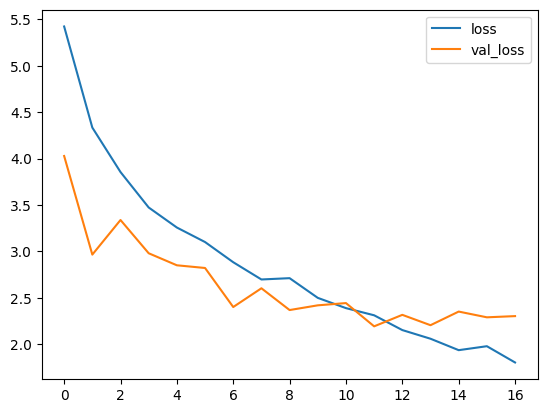

In [12]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))